In [2]:
!pip install transformers
!pip install sentencepiece
!pip install nltk
!pip install ipywidgets

  Using cached transformers-4.16.2-py3-none-any.whl (3.5 MB)
  Using cached regex-2022.1.18-cp36-cp36m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (748 kB)
  Using cached sacremoses-0.0.47-py2.py3-none-any.whl (895 kB)
  Using cached tokenizers-0.11.5-cp36-cp36m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (6.8 MB)
  Using cached huggingface_hub-0.4.0-py3-none-any.whl (67 kB)
  Using cached filelock-3.4.1-py3-none-any.whl (9.9 kB)
  Using cached sentencepiece-0.1.96-cp36-cp36m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
  Using cached nltk-3.6.7-py3-none-any.whl (1.5 MB)
  Using cached ipywidgets-7.6.5-py2.py3-none-any.whl (121 kB)
  Using cached jupyterlab_widgets-1.0.2-py3-none-any.whl (243 kB)
  Using cached widgetsnbextension-3.5.2-py2.py3-none-any.whl (1.6 MB)
  Using cached nbformat-5.1.3-py3-none-any.whl (178 kB)
  Using cached jedi-0.17.2-py2.py3-none-any.whl (1.4 MB)
  Using cached parso-0.7.1-py2.py3-none-any.whl (109 kB)
  Using cached jsonschema-3.2.0-py2.p

In [4]:
import pandas as pd
import numpy as np
import random
import joblib
import torch

from sklearn import preprocessing
from sklearn import model_selection
# from DataAugmentation 
from DataAugmentation import DataAugmentation
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from importlib import reload
import config
from transformers import XLMRobertaForTokenClassification, XLMRobertaConfig ,BertModel, XLMRobertaTokenizer, XLMRobertaModel, BertForTokenClassification
from data_utils import loadDatafromFile,createTokenizedDf,CompDataset,createkfoldData,createDataloaders
from seqeval.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef,classification_report,f1_score
import engine
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm

In [5]:
# Read the data
def process_data(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags,model_type):
    
    dataObj = loadDatafromFile(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags)
    df= dataObj.createDf() # get dataframe from files
    obj_tokenized = createTokenizedDf(df,model_type)
    df_new= obj_tokenized.convertDf()
#     enc_label = preprocessing.LabelEncoder()
#     df_new['labels']= enc_label.fit_transform(df_new['labels'])
    train_data = CompDataset(df_new,model_type)
    return train_data


In [6]:
# if loading of the non augmented (noise-free) data is needed, then run this
dataset_train = process_data(config.filePath_src,config.filePath_tar, config.filePath_srcTags,config.filePath_tarTags,model_type = 'xlm')
len(dataset_train)

7000

In [7]:
#loading dev/eval data
dataset_eval = process_data(config.filePath_src_eval,config.filePath_tar_eval, config.filePath_srcTags_eval,config.filePath_tarTags_eval,model_type = 'xlm')
len(dataset_eval)

1000

In [8]:
dataset_train[0]

(tensor([     0,  17151,  12426,   2765,    113,    527, 110896,  36997,     71,
          20387,   2189,    141,     99, 183124,     23,  58020,      6,      5,
              2,      2,    656,  58020,    656, 138438,     13,    656,  17151,
            656,  12426,   2765,    656,    113,    656,    527, 110896,    656,
          20387,   2189,    141,    656,     23,    656, 183124,    656,      6,
              5,    656,      2,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,    

In [33]:
# def random_deletion(dataframe, p):
    
#     source_sentences  = list(dataframe.source)
#     target_sentences = list(dataframe.target)
#     labels_src = list(dataframe.src_tokens)
#     labels_tar = list(dataframe.tar_tokens)
#     senetences_temp=[]
#     labels_temp= []
#     #randomly delete words with probability p
#     i=0
#     for sentences, labels in zip(source_sentences,labels_src):
            
#         sentences = sentences.split()
#         labels = labels.split() 
        
        
        
#         if len(sentences) == 1:
#             i+=1
#             continue
            
        
               
#         for _ in range(5):
            
#             source_sentences_temp=[]
#             labels_sec_temp=[]
#             for word,label in zip(sentences,labels):
#                 r = random.uniform(0, 1)
#                 if r > p:
#                     source_sentences_temp.append(word)
#                     labels_sec_temp.append(label)
#             if len(source_sentences_temp) == 0: #if you end up deleting all words, just return a random word
#                 rand_int = random.randint(0, len(source_sentences_temp)-1)
#                 source_sentences_temp.append(sentences[rand_int])
#                 labels_sec_temp.append(labels[rand_int])
#             assert(len(source_sentences_temp) == len(labels_sec_temp))
#             sentences_str = ' '.join(source_sentences_temp)
#             labels_str = ' '.join(labels_sec_temp)
#             senetences_temp.append(sentences_str)
#             labels_temp.append(labels_str)
#             target_sentences.append(target_sentences[i])
#             labels_tar.append(labels_tar[i])
# #         break
#         i+=1
#     source_sentences.extend(senetences_temp)
#     labels_src.extend(labels_temp)    
#     column_names = ["source","target","src_tokens","tar_tokens"]
#     df = pd.DataFrame(columns=column_names,dtype=object)
#     df = df.assign(source=source_sentences)
#     df = df.assign(target = target_sentences)
#     df = df.assign(src_tokens = labels_src)
#     df = df.assign(tar_tokens = labels_tar)  


#     return df

In [9]:
# dataloaders
loader_obj = createDataloaders(dataset_train,config.TRAIN_BATCH_SIZE)
train_dataloader = loader_obj.createDataloaders()
len(train_dataloader)

875

In [10]:
loader_obj = createDataloaders(dataset_eval,config.VALID_BATCH_SIZE)
val_dataloader = loader_obj.createDataloaders()
len(val_dataloader)

125

In [11]:
batch = next(iter(val_dataloader))
batch[0][0]

[2022-02-23 14:06:50.613 pytorch-1-6-gpu-p-ml-g4dn-12xlarge-5c3490cc3803aef3e3308aaea43f:31 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-02-23 14:06:50.645 pytorch-1-6-gpu-p-ml-g4dn-12xlarge-5c3490cc3803aef3e3308aaea43f:31 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


tensor([     0, 101044,  25958,      6,      4, 148113,    242,   5117,  17669,
         51521,  49953,  19175,  44978,  12126,   5501,  55741,  74918,   2822,
            98,  20414,    427,      6,      4,  45604,      6,      5,      2,
             2,    656,  36630,     19,   9370,    656,  67271,    656,   3657,
         40255,     67,    656,    833,    656, 148113,    656,    242,    656,
         26431,    656, 168614,     13,    656,  49953,    656,  19175,    656,
         44978,  12126,    656,  10142,  55741,    656,    444,    656,   5035,
           656,  19838,    656,  45604,    656,      6,      5,    656,      2,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1, 

In [15]:
def loss_fn(output,target,mask):
    lfn = nn.CrossEntropyLoss()
    active_loss = mask.view(-1) == 1 #loss calculation for non padded tokens only (mask =1)
    active_logits = output.view(-1,2)
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target)    
    )
    loss = lfn(active_logits,active_labels)
    return loss

In [8]:
class EntityModel(nn.Module):
    
    def __init__(self):
        
        super(EntityModel, self).__init__()
        self.bert = XLMRobertaForTokenClassification.from_pretrained(config.BASE_MODEL_LARGE,output_attentions = False, output_hidden_states = False)
#         self.bert_drop_1 = nn.Dropout(0.3)
#         self.out_tag = nn.Linear(768, 2)
    
    def forward(self, ids, attention_mask, labels):
        
        outputs = self.bert(ids,
                                attention_mask = attention_mask,
                                labels = labels,return_dict=False)
#         bo_tag = self.bert_drop_1(output_1)
        
#         tag = self.out_tag(bo_tag)  
        
#         loss_tag = loss_fn(outputs[1],labels,attention_mask)
        
#         return bo_tag,loss
        return outputs[0], outputs[1]
        

In [12]:
# b_input_ids = batch[0].cuda()
# b_input_mask = batch[1].cuda()
# b_labels = batch[2].cuda()
# outputs = model(b_input_ids, 
#                 b_input_mask,
#                 labels=b_labels)

In [12]:
model = EntityModel()
model.cuda()
model = nn.DataParallel(model)


Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForTokenClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-

In [13]:
print(model)

DataParallel(
  (module): EntityModel(
    (bert): XLMRobertaForTokenClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(250002, 1024, padding_idx=1)
          (position_embeddings): Embedding(514, 1024, padding_idx=1)
          (token_type_embeddings): Embedding(1, 1024)
          (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0): RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): Linear(in_features=1024, out_features=1024, bias=True)
                  (key): Linear(in_features=1024, out_features=1024, bias=True)
                  (value): Linear(in_features=1024, out_features=1024, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
    

In [38]:
# torch.cuda.memory_summary(device=None, abbreviated=False)
# torch.cuda.empty_cache()
# outputs[0]

In [14]:
class EarlyStopping(object):
    def __init__(self, mode='max', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = 0
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            print('terminating because of early stopping!')
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best 
            if mode == 'max':
                self.is_better = lambda a, best: a > best 
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [15]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]
num_train_steps = int(len(dataset_train) / config.TRAIN_BATCH_SIZE * config.EPOCHS) #10 is the batchsize
optimizer = AdamW(optimizer_parameters, lr=2e-5) # used 3e-5
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
)
early_stopping = EarlyStopping(patience=4)

In [17]:
config.EPOCHS

20

In [16]:
loss_test,f1_score_0_test, f1_score_1_test, accuracy_score_test, mcc_score_test,labels_test,preds_test = engine.eval_fn(val_dataloader, model)
print(classification_report(labels_test,preds_test)) # validation data

  0%|          | 0/125 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 125/125 [01:20<00:00,  1.54it/s]


Average F1 Validation score for class 0 : 0.23301044061663717
Average F1 Validation score for class 1 : 3.276056937869581e-05
Average Accuracy Validation score  : 0.13188094594786764
Average mcc Validation score  : -0.00580211431471599
              precision    recall  f1-score   support

           0       0.13      1.00      0.23      9274
           1       0.50      0.00      0.00     61047

    accuracy                           0.13     70321
   macro avg       0.32      0.50      0.12     70321
weighted avg       0.45      0.13      0.03     70321



In [17]:
loss_test,f1_score_0_test, f1_score_1_test, accuracy_score_test, mcc_score_test,labels_test,preds_test = engine.eval_fn(train_dataloader, model)
print(classification_report(labels_test,preds_test))

  0%|          | 0/438 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 438/438 [04:24<00:00,  1.66it/s]


Average F1 Validation score for class 0 : 0.22455437859639002
Average F1 Validation score for class 1 : 4.677082529459773e-05
Average Accuracy Validation score  : 0.12649560078362637
Average mcc Validation score  : 0.000507264119834074
              precision    recall  f1-score   support

           0       0.13      1.00      0.22     61913
           1       0.91      0.00      0.00    427606

    accuracy                           0.13    489519
   macro avg       0.52      0.50      0.11    489519
weighted avg       0.81      0.13      0.03    489519



In [22]:
engine = reload(engine)

In [18]:
for name,param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = True

In [20]:
best_accuracy = -1
train_loss_lst = []
val_loss_lst = []
with open('metrics_xlmroberta_large_earlyStopping.txt', 'w') as f:
    for epoch in range(config.EPOCHS):
            print(f'Epoch {epoch+1} of {config.EPOCHS}')
            train_metrics = engine.train_fn(train_dataloader, model, optimizer, scheduler)
            print(classification_report(train_metrics[5],train_metrics[6]))
            test_metrics = engine.eval_fn(val_dataloader, model)
            print(classification_report(test_metrics[5],test_metrics[6]))
            print(f"Train Loss = {train_metrics[0]} Valid Loss = {test_metrics[0]}")
            train_loss_lst.append(train_metrics[:-2])
            val_loss_lst.append(test_metrics[:-2])
            f.write(f"Train_loss {epoch+1} : {str(train_loss_lst)}" + '\n')
            f.write(f"val_loss {epoch+1} : {str(val_loss_lst)}" + '\n')
            if early_stopping.step(float("{:.2f}".format(test_metrics[4]))): #mcc score for early stopping "{:.2f}".format(a_float)
                  break  # early stop criterion is met, we can stop now
            if test_metrics[4] >  best_accuracy:
                torch.save(model.state_dict(), '../models/training_data/model_xlmrobertatokenclassificationmodel_large_TrainData_earlystopping.bin')
                best_accuracy = test_metrics[4]

  0%|          | 0/438 [00:00<?, ?it/s]

Epoch 1 of 20


/opt/conda/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 438/438 [11:53<00:00,  1.63s/it]


Average F1 Training score for class 0 : 0.37535994579639775
Average F1 Training score for class 1 : 0.9378820258219416
Average Accuracy Training score  : 0.8870013217055926
Average mcc Training score  : 0.3589792236332131


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.62      0.27      0.38     61913
           1       0.90      0.98      0.94    427606

    accuracy                           0.89    489519
   macro avg       0.76      0.62      0.66    489519
weighted avg       0.87      0.89      0.87    489519



/opt/conda/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 125/125 [01:05<00:00,  1.89it/s]


Average F1 Validation score for class 0 : 0.27272727272727276
Average F1 Validation score for class 1 : 0.9350651362361944
Average Accuracy Validation score  : 0.8807753018301787
Average mcc Validation score  : 0.30415558843079243
              precision    recall  f1-score   support

           0       0.70      0.17      0.27      9274
           1       0.89      0.99      0.94     61047

    accuracy                           0.88     70321
   macro avg       0.79      0.58      0.60     70321
weighted avg       0.86      0.88      0.85     70321

Train Loss = 0.27961182083985575 Valid Loss = 0.2967816752195358


  0%|          | 0/438 [00:00<?, ?it/s]

Epoch 2 of 20


/opt/conda/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 438/438 [11:52<00:00,  1.63s/it]


Average F1 Training score for class 0 : 0.5480623907223928
Average F1 Training score for class 1 : 0.9478802239677376
Average Accuracy Training score  : 0.906538867745685
Average mcc Training score  : 0.5148384740744265


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.71      0.45      0.55     61913
           1       0.92      0.97      0.95    427606

    accuracy                           0.91    489519
   macro avg       0.81      0.71      0.75    489519
weighted avg       0.90      0.91      0.90    489519



/opt/conda/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Average F1 Validation score for class 0 : 0.4032105071141919
Average F1 Validation score for class 1 : 0.9355664621032481
Average Accuracy Validation score  : 0.8836905049700658
Average mcc Validation score  : 0.376828101111444
              precision    recall  f1-score   support

           0       0.62      0.30      0.40      9274
           1       0.90      0.97      0.94     61047

    accuracy                           0.88     70321
   macro avg       0.76      0.64      0.67     70321
weighted avg       0.86      0.88      0.87     70321

Train Loss = 0.23332608504790694 Valid Loss = 0.32736343014240266


  0%|          | 0/438 [00:00<?, ?it/s]

Epoch 3 of 20


/opt/conda/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 438/438 [11:51<00:00,  1.62s/it]


Average F1 Training score for class 0 : 0.6644658463609163
Average F1 Training score for class 1 : 0.9575470124119903
Average Accuracy Training score  : 0.9246300960739011
Average mcc Training score  : 0.6291273661273619


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.76      0.59      0.66     61913
           1       0.94      0.97      0.96    427606

    accuracy                           0.92    489519
   macro avg       0.85      0.78      0.81    489519
weighted avg       0.92      0.92      0.92    489519



/opt/conda/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
  0%|          | 0/438 [00:00<?, ?it/s]

Average F1 Validation score for class 0 : 0.38631200996556014
Average F1 Validation score for class 1 : 0.9340525217528248
Average Accuracy Validation score  : 0.8809032863582713
Average mcc Validation score  : 0.35838114469332516
              precision    recall  f1-score   support

           0       0.60      0.28      0.39      9274
           1       0.90      0.97      0.93     61047

    accuracy                           0.88     70321
   macro avg       0.75      0.63      0.66     70321
weighted avg       0.86      0.88      0.86     70321

Train Loss = 0.190123463755465 Valid Loss = 0.40511770701408384
Epoch 4 of 20


/opt/conda/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 438/438 [11:54<00:00,  1.63s/it]


Average F1 Training score for class 0 : 0.7367988386126317
Average F1 Training score for class 1 : 0.965194543259334
Average Accuracy Training score  : 0.9385192403154934
Average mcc Training score  : 0.705372919477165


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.80      0.68      0.74     61913
           1       0.95      0.98      0.97    427606

    accuracy                           0.94    489519
   macro avg       0.88      0.83      0.85    489519
weighted avg       0.94      0.94      0.94    489519



/opt/conda/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 125/125 [01:05<00:00,  1.89it/s]


Average F1 Validation score for class 0 : 0.42512277789306213
Average F1 Validation score for class 1 : 0.9341363870507587
Average Accuracy Validation score  : 0.881813398558041
Average mcc Validation score  : 0.38433635897142127
              precision    recall  f1-score   support

           0       0.59      0.33      0.43      9274
           1       0.90      0.97      0.93     61047

    accuracy                           0.88     70321
   macro avg       0.75      0.65      0.68     70321
weighted avg       0.86      0.88      0.87     70321

Train Loss = 0.15697740817859293 Valid Loss = 0.43211398339271545


  0%|          | 0/438 [00:00<?, ?it/s]

Epoch 5 of 20


/opt/conda/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 438/438 [11:53<00:00,  1.63s/it]


Average F1 Training score for class 0 : 0.7865732923034724
Average F1 Training score for class 1 : 0.9711274097695317
Average Accuracy Training score  : 0.9491357843107213
Average mcc Training score  : 0.7596701191533913


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.84      0.74      0.79     61913
           1       0.96      0.98      0.97    427606

    accuracy                           0.95    489519
   macro avg       0.90      0.86      0.88    489519
weighted avg       0.95      0.95      0.95    489519



/opt/conda/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
  0%|          | 0/438 [00:00<?, ?it/s]

Average F1 Validation score for class 0 : 0.3759104903506795
Average F1 Validation score for class 1 : 0.9347260946397015
Average Accuracy Validation score  : 0.881813398558041
Average mcc Validation score  : 0.3556362894918728
              precision    recall  f1-score   support

           0       0.62      0.27      0.38      9274
           1       0.90      0.97      0.93     61047

    accuracy                           0.88     70321
   macro avg       0.76      0.62      0.66     70321
weighted avg       0.86      0.88      0.86     70321

Train Loss = 0.13109237617349515 Valid Loss = 0.5359024628400803
Epoch 6 of 20


/opt/conda/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 438/438 [11:54<00:00,  1.63s/it]


Average F1 Training score for class 0 : 0.8194411754816583
Average F1 Training score for class 1 : 0.9750254047907505
Average Accuracy Training score  : 0.9561201914532429
Average mcc Training score  : 0.7953748553471507


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.85      0.79      0.82     61913
           1       0.97      0.98      0.98    427606

    accuracy                           0.96    489519
   macro avg       0.91      0.88      0.90    489519
weighted avg       0.95      0.96      0.96    489519



/opt/conda/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 125/125 [01:05<00:00,  1.89it/s]


Average F1 Validation score for class 0 : 0.40324684736918387
Average F1 Validation score for class 1 : 0.9350856169783357
Average Accuracy Validation score  : 0.8829083772983888
Average mcc Validation score  : 0.3743519337564019
              precision    recall  f1-score   support

           0       0.61      0.30      0.40      9274
           1       0.90      0.97      0.94     61047

    accuracy                           0.88     70321
   macro avg       0.76      0.64      0.67     70321
weighted avg       0.86      0.88      0.86     70321

Train Loss = 0.1117737358606093 Valid Loss = 0.5453287327289581
terminating because of early stopping!


In [21]:
train_metrices = np.array(train_loss_lst)
test_metrices = np.array(val_loss_lst)
loss_train = train_metrices[:,0]
loss_test = test_metrices[:,0]
f1_class0_train = train_metrices[:,1]
f1_class0_test= test_metrices[:,1]
f1_class1_train = train_metrices[:,2]
f1_class1_test = test_metrices[:,2]
accuracy_score_train = train_metrices[:,3]
accuracy_score_test = test_metrices[:,3]
mcc_score_train = train_metrices[:,4]
mcc_score_test = test_metrices[:,4]
print('loss_train :',list(loss_train),'\n','loss_test : ',list(loss_test),'\n','f1_class0_train :',list(f1_class0_train),'\n','f1_class0_test :',list(f1_class0_test),'\n','f1_class1_train :',list(f1_class1_train),'\n','f1_class1_test :',list(f1_class1_test),'\n','accuracy_score_train :',list(accuracy_score_train),'\n','accuracy_score_test :',list(accuracy_score_test),'\n','mcc_score_train :',list(mcc_score_train),'\n',
    'mcc_score_test :', list(mcc_score_test))

loss_train : [0.27961182083985575, 0.23332608504790694, 0.190123463755465, 0.15697740817859293, 0.13109237617349515, 0.1117737358606093] 
 loss_test :  [0.2967816752195358, 0.32736343014240266, 0.40511770701408384, 0.43211398339271545, 0.5359024628400803, 0.5453287327289581] 
 f1_class0_train : [0.37535994579639775, 0.5480623907223928, 0.6644658463609163, 0.7367988386126317, 0.7865732923034724, 0.8194411754816583] 
 f1_class0_test : [0.27272727272727276, 0.4032105071141919, 0.38631200996556014, 0.42512277789306213, 0.3759104903506795, 0.40324684736918387] 
 f1_class1_train : [0.9378820258219416, 0.9478802239677376, 0.9575470124119903, 0.965194543259334, 0.9711274097695317, 0.9750254047907505] 
 f1_class1_test : [0.9350651362361944, 0.9355664621032481, 0.9340525217528248, 0.9341363870507587, 0.9347260946397015, 0.9350856169783357] 
 accuracy_score_train : [0.8870013217055926, 0.906538867745685, 0.9246300960739011, 0.9385192403154934, 0.9491357843107213, 0.9561201914532429] 
 accuracy_sc

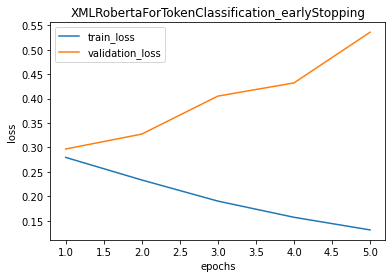

In [22]:

epochs = np.arange(1,epoch+1)
plt.plot(epochs,loss_train[:-1],label='train_loss')
plt.plot(epochs,loss_test[:-1],label='validation_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
# plt.ylim(0.2,0.4)
plt.title('XMLRobertaForTokenClassification_earlyStopping')
plt.legend()
plt.show()

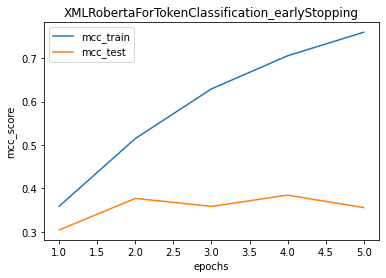

In [23]:
epochs = np.arange(1,epoch+1)
plt.plot(epochs,mcc_score_train[:-1],label='mcc_train')
plt.plot(epochs,mcc_score_test[:-1],label='mcc_test')
plt.xlabel('epochs')
plt.ylabel('mcc_score')
plt.title('XMLRobertaForTokenClassification_earlyStopping')
plt.legend()
plt.show()

In [53]:
from transformers import AutoConfig
config = AutoConfig.from_pretrained('xlm-roberta-base')
config.num_labels

2

In [24]:
print('Max mcc achieved for dev data is', np.amax(mcc_score_test),f',in the {np.argmax(mcc_score_test)+1}th epoch ')

Max mcc achieved for dev data is 0.38433635897142127 ,in the 4th epoch 


In [14]:
model.load_state_dict(torch.load('../models/training_data/model_xlmrobertatokenclassificationmodel_large_TrainData_earlystopping.bin'))
model.eval()

DataParallel(
  (module): EntityModel(
    (bert): XLMRobertaForTokenClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(250002, 1024, padding_idx=1)
          (position_embeddings): Embedding(514, 1024, padding_idx=1)
          (token_type_embeddings): Embedding(1, 1024)
          (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0): RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): Linear(in_features=1024, out_features=1024, bias=True)
                  (key): Linear(in_features=1024, out_features=1024, bias=True)
                  (value): Linear(in_features=1024, out_features=1024, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
    

In [89]:
batch = next(iter(val_dataloader))
input_ids_b = batch[0].cuda()
attention_mask_b = batch[1].cuda()
labels_b = batch[2].cuda()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.INFO:numexpr.utils:NumExpr defaulting to 4 threads.



In [90]:
outputs_pred = model(input_ids_b, attention_mask = attention_mask_b, labels = labels_b )
labels = labels_b.view(-1) 
active_logits = outputs_pred[1].view(-1, 2)
flattened_predictions = torch.argmax(active_logits, axis=1)
active_accuracy = labels.view(-1) != -100
labels_tmp = torch.masked_select(labels, active_accuracy) 
pred_tmp = torch.masked_select(flattened_predictions, active_accuracy)
print('f1 score for class 0 :',f1_score(labels_tmp.tolist(),pred_tmp.tolist(),average='binary',pos_label = 0))
print('f1 score for class 1 :',f1_score(labels_tmp.tolist(),pred_tmp.tolist(),average='binary',pos_label = 1) )    
print('accuracy score :',accuracy_score(labels_tmp.tolist(),pred_tmp.tolist()))
print('mcc score :',matthews_corrcoef(labels_tmp.tolist(),pred_tmp.tolist()))
print(classification_report(labels_tmp.tolist(),pred_tmp.tolist()))

f1 score for class 0 : 0.46715328467153283
f1 score for class 1 : 0.9293320425943853
accuracy score : 0.8752136752136752
mcc score : 0.5064481131096255
              precision    recall  f1-score   support

           0       0.97      0.31      0.47       104
           1       0.87      1.00      0.93       481

    accuracy                           0.88       585
   macro avg       0.92      0.65      0.70       585
weighted avg       0.89      0.88      0.85       585



In [91]:
print('f1 score overall :',f1_score(labels_tmp.tolist(),pred_tmp.tolist()) )    


f1 score overall : 0.9293320425943853


In [36]:
print(input_ids_b[0])
print(attention_mask_b[0])
print(labels_b[0])

tensor([     0,    241,    147,    538,  12610,      6, 101287,      7,     47,
         64372, 176016,     71,    604, 102917,    538,    237,     10,   1926,
         87463,    136,  32926,    111,   1926,  23962,      6,      5,      2,
             2,    656, 180702,     13,    656,  45445,     39,   4986,    656,
           360,  37738,     33,    656,    142,    656,  64372,    656,   3820,
         42001,    656,   1329,    656,   1248,    656,  18341,    656,    737,
           656,  25357,   1505,     73,    656,    165,    656,  60150,  38982,
         45118,    656,    542,    656,  25357,   1505,     19,    656,      6,
             5,    656,      2,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1, 

In [46]:
print(input_ids_b.tolist())


tensor([-3.0275e-22,  3.0688e-41])

In [49]:
outputs_pred[1]

tensor([[[-1.5755,  2.1431],
         [-2.0731,  2.5395],
         [-2.0786,  2.6243],
         ...,
         [-1.2857,  2.2847],
         [-1.2857,  2.2847],
         [-1.2857,  2.2847]],

        [[-0.8680,  1.7539],
         [-0.2165,  0.4778],
         [-0.6057,  0.5730],
         ...,
         [-0.8171,  2.1133],
         [-0.8171,  2.1133],
         [-0.8171,  2.1133]],

        [[-2.3140,  3.1032],
         [-1.3967,  1.9284],
         [-2.1930,  2.8714],
         ...,
         [-0.7345,  1.8473],
         [-0.7345,  1.8473],
         [-0.7345,  1.8473]],

        ...,

        [[-1.8779,  2.5788],
         [-1.1160,  1.6957],
         [-1.4398,  1.4903],
         ...,
         [-0.5970,  0.9176],
         [-0.5970,  0.9176],
         [-0.5970,  0.9176]],

        [[-3.4575,  4.1277],
         [-4.0676,  4.2741],
         [-4.1043,  4.3594],
         ...,
         [-2.8568,  3.8547],
         [-2.8568,  3.8547],
         [-2.8568,  3.8547]],

        [[-3.2421,  4.1605],
       

In [51]:
flattened_predictions.shape

torch.Size([2048])

In [53]:
pred_tmp

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [92]:
pred_tmp

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [55]:
labels_tmp

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [56]:
pred_tmp

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [16]:
input_ids_b

tensor([[     0,  10257,  48461,  ...,      1,      1,      1],
        [     0, 136820,     13,  ...,      1,      1,      1],
        [     0, 106073,  81887,  ...,      1,      1,      1],
        ...,
        [     0,    360,    903,  ...,      1,      1,      1],
        [     0,   1840,  16145,  ...,      1,      1,      1],
        [     0,    360, 159261,  ...,      1,      1,      1]],
       device='cuda:0')

In [21]:
np_arr = input_ids_b.cpu().numpy()

In [68]:
src_labels=[]
tar_lables=[]
index_labels = []
for items in np_arr:
#     print(np.where(items==2))
    index_labels_tmp=np.where(items==2)
    index_labels.append(index_labels_tmp[0])
index_labels

[array([17, 18, 44]),
 array([14, 15, 41]),
 array([23, 24, 59]),
 array([21, 22, 59]),
 array([36, 37, 95]),
 array([ 51,  52, 140]),
 array([ 56,  57, 147]),
 array([27, 28, 64])]

In [69]:
np_arr_labels = labels_b.cpu().numpy()

In [251]:
def div_src_tar(input_id, labels):
    
    src_labels=[]
    tar_labels=[]
    src_labels_example = []
    tar_labels_example = []
    index_labels=[]
    input_id_np = input_id.cpu().numpy()
    np_arr_labels = labels.cpu().numpy()
    
    for items in input_id_np:
        
        index_labels_tmp=np.where(items==2)
        index_labels.append(index_labels_tmp[0])
    
    for i,items in enumerate(index_labels):

        src_labels.extend(np_arr_labels[i][:items[1]])
        tar_labels.extend(np_arr_labels[i][items[1]:])
        src_labels_example.append(np_arr_labels[i][:items[0]])
        tar_labels_example.append(np_arr_labels[i][items[1]+1:])
    #     (src_labels_tmp)
    
    #     print(src_labels_tmp,f'{i}th sentence')
    # print(src_labels)
    # print(tar_labels)
    return src_labels, tar_labels,src_labels_example,tar_labels_example

In [290]:
active_logits.shape

torch.Size([2048, 2])

In [206]:
print(torch.Tensor(tar_labels).view(-1).shape)

torch.Size([1822])


In [252]:
src_labels , tar_labels, src_labels_example, tar_labels_example = div_src_tar(input_ids_b,labels_b)

In [253]:
labels_pred=[]
for i in range(config.VALID_BATCH_SIZE):
        labels_pred.append(flattened_predictions[i*config.MAX_LEN:(i+1)*config.MAX_LEN])
#         labels_pred.append(flattened_predictions[])
labels_pred_torch = torch.stack(labels_pred)

In [254]:
src_labels_pred, tar_labels_pred , src_labels_pred_example, tar_labels_pred_example = div_src_tar(input_ids_b, labels_pred_torch)

In [247]:
def get_gaps_labels(labels):
    gap_labels = []
    tar_labels = []
    for item in labels:
        for j,label in enumerate(item):
            if j%2==0:
                gap_labels.append(label)
            else:
                tar_labels.append(label)
    return gap_labels, tar_labels 

In [248]:
gap_labels, tr_labels = get_gaps_labels(tar_labels_example)
gap_labels_pred, tr_labels_pred = get_gaps_labels(tar_labels_pred_example) 

In [262]:
print(len(src_labels))
print(len(src_labels_pred))
print(len(tar_labels))
print(len(tar_labels_pred))
print(len(gap_labels))
print(len(gap_labels_pred))
print(len(tr_labels))
print(len(tr_labels_pred))

226
226
1822
1822
909
909
905
905


In [261]:
tensor_src_labels = torch.Tensor(src_labels)
tensor_tar_labels = torch.Tensor(tar_labels)
tensor_src_labels_pred = torch.Tensor(src_labels_pred)
tensor_tar_labels_pred = torch.Tensor(tar_labels_pred)
tensor_gap_labels = torch.Tensor(gap_labels)
tensor_gap_labels_pred = torch.Tensor(gap_labels_pred)
tensor_target_labels = torch.Tensor(tr_labels)
tensor_target_labels_pred = torch.Tensor(tr_labels_pred)

In [265]:
active_accuracy = tensor_src_labels.view(-1) != -100
src_labels_active = torch.masked_select(tensor_src_labels, active_accuracy) 
src_labels_active_pred = torch.masked_select(tensor_src_labels_pred, active_accuracy)
print(len(src_labels_active))
print(len(src_labels_active_pred))

210
210


In [291]:
print('MCC Score for source :',matthews_corrcoef(src_labels_active.tolist(),src_labels_active_pred.tolist()) )
print('F1 Score for source :',f1_score(src_labels_active,src_labels_active_pred))
print(classification_report(src_labels_active,src_labels_active_pred))

MCC Score for source : 0.4167846642725389
F1 Score for source : 0.9100817438692098
              precision    recall  f1-score   support

         0.0       0.91      0.24      0.38        42
         1.0       0.84      0.99      0.91       168

    accuracy                           0.84       210
   macro avg       0.87      0.62      0.64       210
weighted avg       0.85      0.84      0.80       210



In [272]:
active_accuracy = tensor_gap_labels.view(-1) != -100
gap_labels_active = torch.masked_select(tensor_gap_labels, active_accuracy) 
gap_labels_active_pred = torch.masked_select(tensor_gap_labels_pred, active_accuracy)
print(len(gap_labels_active))
print(len(gap_labels_active_pred))

189
189


In [279]:
print('MCC Score for gap :',matthews_corrcoef(gap_labels_active,gap_labels_active_pred) )
print('F1 Score for gap :',f1_score(gap_labels_active,gap_labels_active_pred))
print(classification_report(gap_labels_active,gap_labels_active_pred))

MCC Score for gap : 0.6264982043070835
F1 Score for gap : 0.9457831325301205
              precision    recall  f1-score   support

         0.0       1.00      0.44      0.61        32
         1.0       0.90      1.00      0.95       157

    accuracy                           0.90       189
   macro avg       0.95      0.72      0.78       189
weighted avg       0.91      0.90      0.89       189



In [280]:
active_accuracy = tensor_tar_labels.view(-1) != -100
tar_labels_active = torch.masked_select(tensor_tar_labels, active_accuracy) 
tar_labels_active_pred = torch.masked_select(tensor_tar_labels_pred, active_accuracy)
print(len(tar_labels_active))
print(len(tar_labels_active_pred))

375
375


In [282]:
print('MCC Score for tar :',matthews_corrcoef(tar_labels_active,tar_labels_active_pred) )
print('F1 Score for tar :',f1_score(tar_labels_active,tar_labels_active_pred))
print(classification_report(tar_labels_active,tar_labels_active_pred))

MCC Score for tar : 0.5609192074675643
F1 Score for tar : 0.93993993993994
              precision    recall  f1-score   support

         0.0       1.00      0.35      0.52        62
         1.0       0.89      1.00      0.94       313

    accuracy                           0.89       375
   macro avg       0.94      0.68      0.73       375
weighted avg       0.91      0.89      0.87       375



In [283]:
active_accuracy = tensor_target_labels.view(-1) != -100
target_labels_active = torch.masked_select(tensor_target_labels, active_accuracy) 
target_labels_active_pred = torch.masked_select(tensor_target_labels_pred, active_accuracy)
print(len(target_labels_active))
print(len(target_labels_active_pred))

186
186


In [285]:
print('MCC Score for tar :',matthews_corrcoef(target_labels_active,target_labels_active_pred) )
print('F1 Score for tar :',f1_score(target_labels_active,target_labels_active_pred))
print(classification_report(target_labels_active,target_labels_active_pred))

MCC Score for tar : 0.4834334133761747
F1 Score for tar : 0.9341317365269461
              precision    recall  f1-score   support

         0.0       1.00      0.27      0.42        30
         1.0       0.88      1.00      0.93       156

    accuracy                           0.88       186
   macro avg       0.94      0.63      0.68       186
weighted avg       0.90      0.88      0.85       186



In [183]:
# print(len(src_labels_pred))
# src_labels_rem_ind = [i for i,item in enumerate(src_labels) if item==-100]
# print(src_labels_rem_ind)
# for item in src_labels_rem_ind:
#     src_labels_pred.pop(item)
# print(len(src_labels_pred))
# src_labels_rem = [item for item in src_labels if item!=-100]
# print(len(src_labels_rem))

226
[0, 41, 42, 62, 63, 80, 81, 109, 110, 147, 148, 170, 171, 197, 198, 225]


IndexError: pop index out of range

In [156]:
print(src_labels)

[-100, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -10

In [136]:
len(tar_labels[0]) 

214

In [133]:
len(src_labels_pred[0])

42

In [132]:
len(tar_labels_pred[0])

214

In [131]:
active_logits.shape[0]

2048

In [107]:
flattened_predictions_np = flattened_predictions.cpu().numpy()

In [122]:
type(labels_b[0])

torch.Tensor

In [123]:
len(tar_labels[0])

214

In [87]:
len(src_labels[0])

18

In [137]:
1%2

1